# LangChain Agents Bootcamp - Financial Analysis with Gemini

Complete guide to building production-ready agents with memory, middleware, and streaming.

https://docs.langchain.com/oss/python/langchain/middleware/built-in

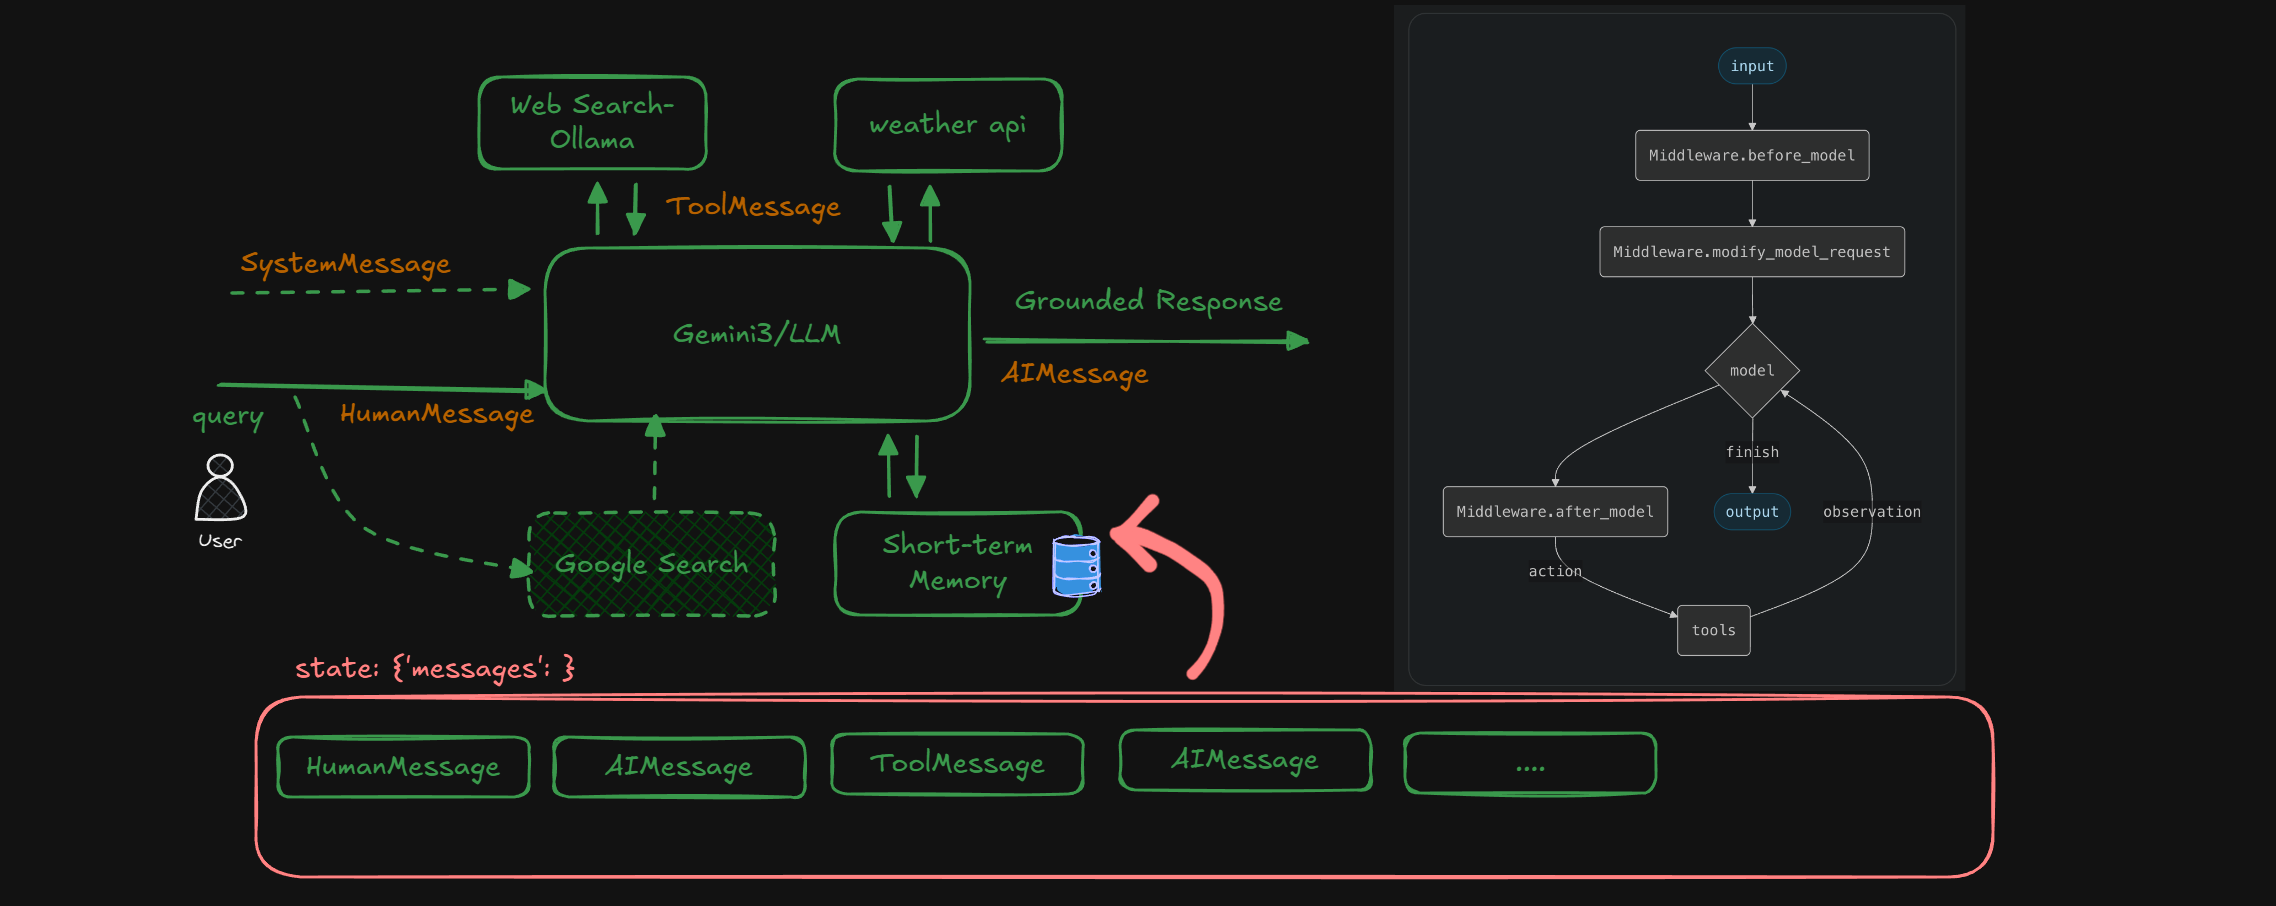

## Overview

This notebook covers:
- **Short-term Memory**: Persist conversation state with SQLite
- **Built-in Middleware**: Production patterns (summarization, limits, PII detection, todo tracking)
- **Structured Output**: Type-safe agent responses with Pydantic
- **Streaming Modes**: Real-time updates (`messages`, `updates`, `values`)

## Setup

Initialize model and tools for financial analysis.

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from scripts import base_tools

In [ ]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash') # gemini-3-pro-preview

In [ ]:
system_prompt = "You are a financial analyst specializing in tech stocks.\nProvide data-driven analysis with clear insights. you have access to web_search tools and get_weather tools."

## 1. Basic Agent

Create a simple agent with tools but no memory.

In [ ]:
agent = create_agent(model=model,
                     tools=[base_tools.web_search, base_tools.get_weather],
                     system_prompt=system_prompt)

agent

In [ ]:
query = "what's apple's current stock price?"
response = agent.invoke({'messages': [HumanMessage(query)]})

In [ ]:
response

In [ ]:
query = "what's apple's current stock price? and what is the latest weather in Mumbai?"
response = agent.invoke({'messages': [HumanMessage(query)]})

In [ ]:
response

In [ ]:
print(response['messages'][-1].text)

## 2. Short-term Memory with SQLite

Add conversation persistence using SQLite checkpointer. Agent remembers previous turns within a session.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("data/financial_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [ ]:
agent_memory = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer = checkpointer)

In [ ]:
config = {"configurable": {"thread_id": "memory_session"}}
response = agent_memory.invoke({'messages': [query]}, config=config)

In [ ]:
response

In [ ]:
response = agent_memory.invoke({'messages': ["what is the latest US stock news"]}, config=config)

In [ ]:
response

In [ ]:
for res in response['messages']:
    if isinstance(res, AIMessage):
        print(res.usage_metadata)

## Built-in Middleware

## 3. Middleware: Summarization

Automatically summarize old messages when history grows too long.

**Use Case**: Long conversations that exceed context windows.

In [ ]:
from langchain.agents.middleware import SummarizationMiddleware

In [ ]:
agent_summary = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        SummarizationMiddleware(
            model=ChatGoogleGenerativeAI(model='gemini-2.5-flash'),
            trigger=[("messages", 15)],
            keep=("messages", 5)
        )
    ]
)

In [ ]:
agent_summary

In [ ]:
response = agent_summary.invoke({'messages': ['what is the stock price of Microsoft and Apple. What is the latest weather in Mumbai. What is the latest news on Asian Stock market?. Use the web search tool.']}, config=config)

In [ ]:
response['messages'][0].pretty_print()

In [ ]:
response['messages'][-1].text

In [ ]:
response

## 4. Middleware: Model and Tool Call Limit

Limit the number of model calls per request to prevent runaway costs.

**Exit Behaviors**: `"end"` (stop) or `"continue"` (proceed without model)

In [ ]:
from langchain.agents.middleware import ModelCallLimitMiddleware
from langchain.agents.middleware import ToolCallLimitMiddleware
from langchain.agents.middleware import ModelFallbackMiddleware

In [ ]:
agent_limit = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        SummarizationMiddleware(
            model=ChatGoogleGenerativeAI(model='gemini-2.5-flash'),
            trigger=[("messages", 15)],
            keep=("messages", 5)
        ),
        ModelCallLimitMiddleware(run_limit=2, exit_behavior="end"),
        ToolCallLimitMiddleware(run_limit=2, exit_behavior='continue'),
        ModelFallbackMiddleware(ChatGoogleGenerativeAI(model='gemini-3-pro-preview'))
    ]
)

In [ ]:
config = {'configurable': {'thread_id': 'limit_session'}}
response = agent_limit.invoke({'messages': ['what is the total distance between earth and moon. what is the latest news on trump. what is the latest weather of London?']}, config)


In [ ]:
response

In [ ]:
response = agent_limit.invoke({'messages': ['tell me 3 facts about the earth']}, config)
response

In [ ]:
agent_limit

## 5. Middleware: Guardrails and PII Detection

Automatically detect and redact/mask personally identifiable information.

**Strategies**: `"redact"` (remove), `"mask"` (replace with ***), `"block"` (prevent request)

In [ ]:
from langchain.agents.middleware import PIIMiddleware


In [ ]:
agent_pii = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        PIIMiddleware("api_key", detector=r"sk-[a-zA-Z0-9]{32}", strategy="block"),
        PIIMiddleware("email", strategy="redact", apply_to_input=True),
        PIIMiddleware("credit_card", strategy="mask", apply_to_input=True),
        PIIMiddleware("url", strategy="redact", apply_to_input=True),
        PIIMiddleware
    ])

In [ ]:
config = {'configurable': {'thread_id': 'pii_session'}}

response = agent_pii.invoke({'messages': [HumanMessage('Hi, my name is laxmi kant. here is my email info@kgptalkie.com')]}, config=config)

In [ ]:
response

In [ ]:
response = agent_pii.invoke({'messages': 
                             [HumanMessage('Hi, my name is laxmi kant. here is my email info@kgptalkie.com. my website is https://kgptalkie.com')]}, config=config)

In [ ]:
response

## 6. Middleware: Todo List

Track and manage multi-step tasks within the agent.

In [ ]:
from langchain.agents.middleware import TodoListMiddleware

In [ ]:
system_prompt

In [ ]:
agent_todo = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[TodoListMiddleware()]
)

In [ ]:
config = {'configurable': {'thread_id': 'todo_session_1'}}

response = agent_todo.invoke(
    {'messages': [HumanMessage("analyze the apple revenue and compare it with competitors")]},
    config=config
)

In [ ]:
response

In [ ]:
print(response['messages'][-1].text)

## 7. Streaming: Messages Mode
Three streaming modes for real-time agent updates:
- **`messages`**: Stream individual messages as they're generated
- **`updates`**: Stream state updates after each step
- **`values`**: Stream complete state values

In [ ]:
config = {'configurable': {'thread_id': 'stream_session'}}
for chunk in agent.stream({'messages':['tell me about the apple news']}, stream_mode='messages', config=config):
    print(chunk)
    print("------\n")

In [ ]:
config = {'configurable': {'thread_id': 'stream_session_1'}}
for chunk in agent.stream({'messages':['tell me about the apple news']}, stream_mode='updates', config=config):
    print(chunk)
    print("------\n")

In [ ]:
config = {'configurable': {'thread_id': 'stream_session_2'}}
for chunk in agent.stream({'messages':['tell me about the apple news']}, stream_mode='values', config=config):
    print(chunk)
    print("------\n")

In [ ]:
agent

## 8. Structured Output

Return type-safe Pydantic models from agent responses.

In [ ]:
from pydantic import BaseModel, Field
from typing import Optional

In [ ]:
class FinancialAnalysis(BaseModel):
    company: str = Field (description="Company Name")
    stock_symbol: str = Field (description="Company Stock Symbol")
    current_price: Optional[str] = Field (description="Company's current stock price")
    analysis: str = Field (description="Company's brief analysis")
    recommendation: str = Field (description="What is recommendation? Buy/Hold/Sell")

In [ ]:
agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    response_format = FinancialAnalysis
)

In [ ]:
response = agent.invoke({'messages': [HumanMessage('Analyze the apple stock')]})

In [ ]:
response

In [ ]:
response['structured_response'].model_dump()